In [ ]:
import os
job_cancel_str="scancel " + os.environ['SLURM_JOBID']
os.system(job_cancel_str)

# Practical Deep Learning Workshop 2021
## Assignment 2 - Time Series
 
### Authors:
 
1.   Naor Kolet 205533060
2.   Chen Doytshman 205644941

# 0. Imports

In [5]:
import pandas as pd
import numpy as np
 
# TensorFlow
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Input, BatchNormalization, Concatenate, Dropout, MaxPool2D, Flatten
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Scikit-learn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

 
# Plots
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Misc.
import pickle
import os
import random
import joblib
from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm

SEED = 42
%matplotlib inline

In [6]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 1. Exploratory Data Analysis (EDA)

## a. General exploratory of the data

### 1.1 Dataset Description

### 1.2 Data Load

First we will load the data to a dictionary.

In [7]:
dat_files = [_ for _ in os.listdir('./PAMAP2_Dataset/Protocol') if _.endswith(".dat")]
columns = ['timestamp', 'activityID', 'heart_rate']
columns += [f'IMU_hand{i}' for i in range(1,18)]
columns += [f'IMU_chest{i}' for i in range(1,18)]
columns += [f'IMU_ankle{i}' for i in range(1,18)]
subjects = {subject.split('.')[0][-3:]: pd.read_csv(f'./PAMAP2_Dataset/Protocol/{subject}', sep=' ', names=columns) for subject in dat_files}

for subject, df in subjects.items():
    df['ID'] = subject
    df.set_index(['ID', 'timestamp'], inplace=True)

In [8]:
id2activity = {
    1: 'lying',
    2: 'sitting',
    3: 'standing',
    4: 'walking',
    5: 'running',
    6: 'cycling',
    7: 'Nordic walking',
    9: 'watching TV',
    10: 'computer work',
    11: 'car driving',
    12: 'ascending stairs',
    13: 'descending stairs',
    16: 'vacuum cleaning',
    17: 'ironing',
    18: 'folding laundry',
    19: 'house cleaning',
    20: 'playing soccer',
    24: 'rope jumping',
    0: 'in transition'
}

### 1.3 Preprocessing

According to the dataset documentation, data labeled with activityID=0 should be discarded in any kind of analysis. This data mainly covers transient activities between performing different activities.

In [9]:
def remove_zero_activity(subjects):
    return {subject : df[df['activityID']!= 0] for subject, df in subjects.items()}

subjects = remove_zero_activity(subjects)

According to the dataset documentation, some missing values (NaNs) are present due to wireless communication dropping or due to problems with hardware setup. We will perform data imputation to fill those missing values.

In [10]:
def impute(subjects):
    return {subject : df.interpolate(method='linear').bfill() for subject, df in subjects.items()}

subjects = impute(subjects)

The values of 'activityID' are not in a continuous range, so we will reindex those values

In [11]:
act_vals = subjects['101']['activityID'].unique()
act_vals.sort()
print(f"Original `activityID` values: \t{act_vals}")
act_vals_map = {n : i for i,n in enumerate(np.unique(act_vals))}
print(f"New `activityID` values: \t{np.array(list(act_vals_map.values()))}")

Original `activityID` values: 	[ 1  2  3  4  5  6  7 12 13 16 17 24]
New `activityID` values: 	[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [12]:
id2activity = {act_vals_map[actId]: actStr for actId, actStr in id2activity.items() if actId in act_vals}

In [13]:
def transform_activityId(df):
    df['activityID'] = df['activityID'].map(act_vals_map)

_ = [transform_activityId(df) for df in subjects.values()]

### 1.4 Data size, structure, samples, etc.

In [14]:
print(f'We have {len(subjects)} subjects in our dataset.')
print(f'Each subject is being measured by {list(subjects.values())[0].shape[1]} metrics.')
print()
print('Number of samples varies across subjects as follows:')
print('----------------------------------------------------')
_ = [print(f'Subject {subject} has {df.shape[0]} samples') for subject, df in subjects.items()]

We have 9 subjects in our dataset.
Each subject is being measured by 53 metrics.

Number of samples varies across subjects as follows:
----------------------------------------------------
Subject 101 has 249957 samples
Subject 102 has 263349 samples
Subject 103 has 174338 samples
Subject 104 has 231421 samples
Subject 105 has 272442 samples
Subject 106 has 250096 samples
Subject 107 has 232776 samples
Subject 108 has 262102 samples
Subject 109 has 6391 samples


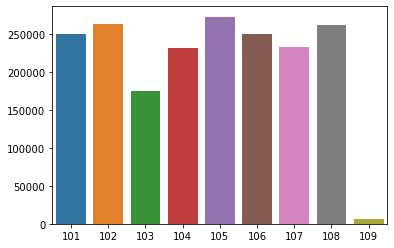

In [15]:
_ = sns.barplot(x=list(subjects.keys()), y=[subject.shape[0] for subject in subjects.values()])

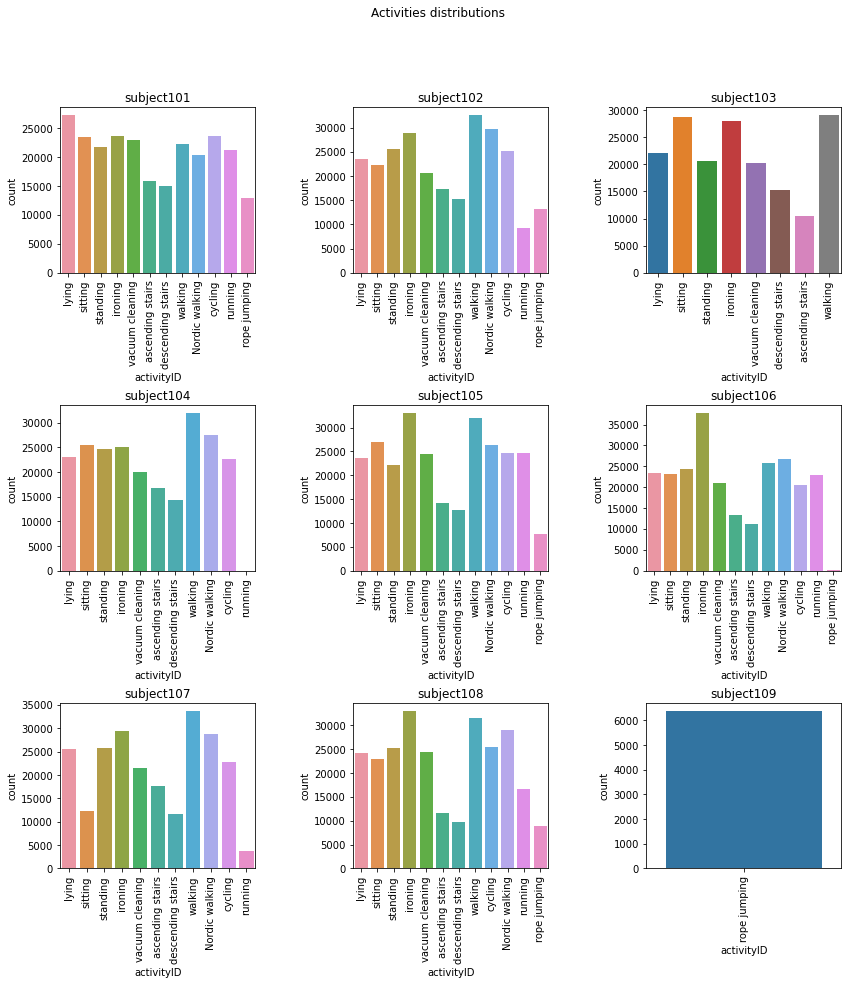

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,14))
fig.subplots_adjust(hspace=0.8, wspace=0.5)
fig.suptitle(f'Activities distributions')

for i in range(3):
    for j in range(3):
        curr_subject = i*3 + j + 1
        curr_subject = f'10{curr_subject}'
        subject_df = subjects[curr_subject]
        sns.countplot(x=subject_df['activityID'].map(id2activity), ax=ax[i][j])
        ax[i][j].set_title(f'subject{curr_subject}')
        ax[i][j].tick_params(axis='x', labelrotation= 90)

One intersting feature of this dataset is heart rate. Let's see how it varies depending on the activity.

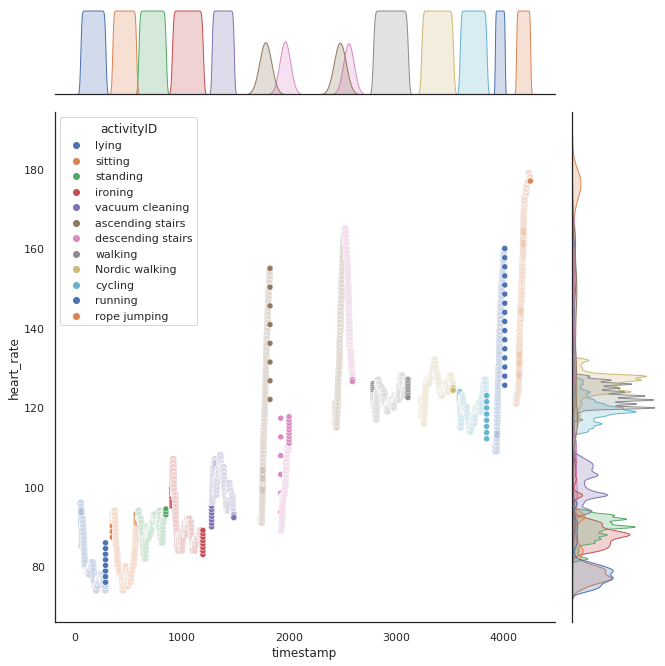

In [17]:
sns.set_theme(style='white')

joint = sns.jointplot(data=subjects['102'],
                x='timestamp', 
                y='heart_rate', 
                hue=subjects['102']['activityID'].map(id2activity), 
                palette='deep')
joint.fig.set_figwidth(10)
joint.fig.set_figheight(10)

### Benchmarks

We identified several benchmark results torely on.



1.  [ Colegues from previous semester](https://www.kaggle.com/roylevy/pamap2-roy-yuval) class achieved 59.96% accuracy on the test set in their last attempt to build a LSTM model.
2.   [Another work](https://www.kaggle.com/avrahamcalev/time-series-models-pamap2-dataset) from previous semester achieved 92.54% accuracy on the test data, using a combination of LSTM, intermediate dense layers and dropout regularization.
3. 



## b. Explain the task at hand

We will define the task as a classification task.
Since the order of the activities is known beforehand there is no need to predict the future activity given the past or the other way around.
We will divide the samples into time series, each record will have one unique activity.
Our mission will be, given the measurements, to predict the activity. 

## c. State self-supervised tasks 

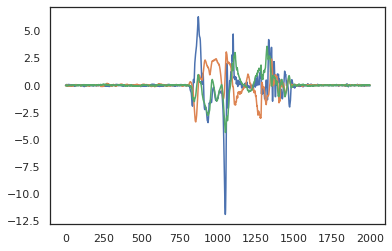

In [17]:
d = subjects['102'][:2000]
# _ = plt.plot(d['heart_rate'].values)
# _ = plt.plot(d['IMU_hand2'])
# _ = plt.plot(d['IMU_hand3'])
# _ = plt.plot(d['IMU_hand4'])
_ = plt.plot(d['IMU_hand8'].values)
_ = plt.plot(d['IMU_hand9'].values)
_ = plt.plot(d['IMU_hand10'].values)


1. 
2. task2

# 2. Forming neural network

## a. The validation strategy 

We have data regarding 9 subjects. As stated in the assignment specification, subjects 107, 108 will be used as our test set. For validation set will will use another two random subjects. It is convinient and easy to understand, and ressembles the test set.

In [18]:
sbjcts = list(subjects.keys())
val_size = 2

test_subjects = ['107', '108']
random.seed(SEED)
val_subjects = random.sample([sbj for sbj in sbjcts if sbj not in test_subjects], val_size)

train_subjects = [sbj for sbj in sbjcts if sbj not in test_subjects+val_subjects]

print('train subjects:\t\t', " ".join(train_subjects))
print('validation subjects:\t', " ".join(val_subjects))
print('test subjects:\t\t', " ".join(test_subjects))

train_subjects_df = {subject: subjects[subject] for subject in train_subjects}
val_subjects_df = {subject: subjects[subject] for subject in val_subjects}
test_subjects_df = {subject: subjects[subject] for subject in test_subjects}

train subjects:		 102 103 104 105 109
validation subjects:	 106 101
test subjects:		 107 108


### Preprocessing for models

In [19]:
def scale_dataframe(data, scaler):
    return pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

from sklearn.compose import make_column_transformer

ct = make_column_transformer(
        ('passthrough', ['activityID']),
    remainder=StandardScaler())

ct.fit(pd.concat(train_subjects_df.values()))

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('passthrough', 'passthrough', ['activityID'])])

In [20]:
train_subjects_df = {subject: scale_dataframe(subjects[subject], ct) for subject in train_subjects}
val_subjects_df = {subject: scale_dataframe(subjects[subject], ct) for subject in val_subjects}
test_subjects_df = {subject: scale_dataframe(subjects[subject], ct) for subject in test_subjects}

In [21]:
for dfs_dict in [train_subjects_df, val_subjects_df, test_subjects_df]:
    for df in dfs_dict.values():
        df.activityID = df.activityID.astype('int64')

## b. Naive basline solution - Logistic Regression

In [22]:
def naive_split_x_y(df):
    return df.drop('activityID', axis = 1).values, df['activityID'].values

In [23]:
def naive_split_train_val_test():
    train = pd.concat(train_subjects_df)
    train_x, train_y = naive_split_x_y(train)
    
    val = pd.concat(val_subjects_df)
    val_x, val_y = naive_split_x_y(val)
    
    test = pd.concat(test_subjects_df)
    test_x, test_y = naive_split_x_y(test)
    
    return train_x, train_y, val_x, val_y, test_x, test_y

In [24]:
naive_train_x, naive_train_y, naive_val_x, naive_val_y, naive_test_x, naive_test_y = naive_split_train_val_test()

naive_train_x = np.append(naive_train_x, naive_val_x, axis=0)
naive_train_y = np.append(naive_train_y, naive_val_y, axis=0)

In [25]:
use_saved = False

if use_saved:
    lr_model = joblib.load('./models/lr_model.sav')
else:
    lr_model = LogisticRegression(random_state=SEED, n_jobs=-1)
    lr_model.fit(naive_train_x, naive_train_y)
    joblib.dump(lr_model, './models/lr_model.sav')

KeyboardInterrupt: 

In [ ]:
train_preds = lr_model.predict(naive_train_x)
test_preds = lr_model.predict(naive_test_x)

test_loss = log_loss(naive_test_y, lr_model.predict_proba(naive_test_x), eps=1e-15)
train_loss = log_loss(naive_train_y, lr_model.predict_proba(naive_train_x), eps=1e-15)

print(f"Logistic Regression: Train Accuracy - {accuracy_score(train_preds, naive_train_y)*100}%  Train loss - {train_loss}")
print(f"Logistic Regression: Test Accuracy - {accuracy_score(test_preds, naive_test_y)*100}%  Test loss - {test_loss}")

## c. Solid Benchmark - Random forest

In [ ]:
use_saved = False

if use_saved:
    rf_model = joblib.laod('./models/rf_model.sav')
else:
    rf_model = RandomForestClassifier(random_state=SEED, n_jobs=-1)
    rf_model.fit(naive_train_x, naive_train_y)
    joblib.dump(rf_model, './models/rf_model.sav')

In [ ]:
train_preds = rf_model.predict(naive_train_x)
test_preds = rf_model.predict(naive_test_x)

test_loss = log_loss(naive_test_y, rf_model.predict_proba(naive_test_x), eps=1e-15)
train_loss = log_loss(naive_train_y, rf_model.predict_proba(naive_train_x), eps=1e-15)

print(f"Random Forest: Accuracy - {accuracy_score(train_preds, naive_train_y)*100}%  loss - {train_loss}")
print(f"Random Forest: Accuracy - {accuracy_score(test_preds, naive_test_y)*100}%  loss - {test_loss}")

## d. Neural Network Model

In [22]:
def split_x_y(df, look_back=150):
    num_of_series = df.shape[0] - look_back + 1
    x = []
    y = []
    
    for i in tqdm(range(num_of_series)):
        serie = df.iloc[i:i+look_back]
        if serie['activityID'].nunique() == 1:
            activity = serie['activityID'].unique()[0]
            x += [serie.values]
            y += [activity]

    return np.array(x), np.array(y)

In [23]:
def split_x_y_list(dfs):
    xs = []
    ys = []
    
    for df in dfs:
        x, y = split_x_y(df)
        xs += [x]
        ys += [y]
        
    return np.concatenate(xs), np.concatenate(ys)

In [24]:
def split_train_val_test():
    train_x, train_y = split_x_y_list(train_subjects_df.values())
    
    val_x, val_y = split_x_y_list(val_subjects_df.values())
    
    test_x, test_y = split_x_y_list(test_subjects_df.values())
    
    return train_x, train_y, val_x, val_y, test_x, test_y

In [ ]:
use_saved = False
if use_saved:
    train_x, train_y, val_x, val_y, test_x, test_y = joblib.load('./objects/nn_splits.sav')
else:
    train_x, train_y, val_x, val_y, test_x, test_y = split_train_val_test()
    joblib.dump((train_x, train_y, val_x, val_y, test_x, test_y), './objects/nn_splits.sav')

100%|██████████| 231272/231272 [01:59<00:00, 1930.17it/s]


In [ ]:
train_y_onehot = to_categorical(train_y)
val_y_onehot = to_categorical(val_y)
test_y_onehot = to_categorical(test_y)

In [ ]:
def get_callbacks(model_name):
    acc = 'val_acc' if not model_name.startswith('ss') else 'val_loss'
    acc_mode = 'max' if not model_name.startswith('ss') else 'min'
    
    checkpoint = ModelCheckpoint(
                              fr'./models/{model_name}.h5', 
                              monitor=acc, 
#                               verbose=1, 
                              save_best_only=True, 
                              mode=acc_mode)
    earlystop = EarlyStopping(monitor=acc, mode=acc_mode, verbose=1, patience=4)
    reduceLR = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 3,
                            factor = 0.5, min_lr = 1e-6, verbose = 1)

    return [checkpoint, reduceLR, earlystop]

In [ ]:
def train_model(model_gen, args=None, batch_size=8192, use_saved=False):
    os.makedirs('./models', exist_ok=True)
    model_name = model_gen.__name__[5:]
    
    train, val, test = ((train_x,train_y_onehot), (val_x,val_y_onehot), (test_x,test_y_onehot))
    if args:
        train, val, test = args
        
    if use_saved:
        history = joblib.load(fr'./models/{model_name}_history.sav')
    else:
        callbacks = get_callbacks(model_name)
            
        history = model_gen(train[0].shape[1:], train[1].shape[1]).fit(x=train[0],
                    y=train[1],
                    batch_size=batch_size,
                    epochs=20,
                    validation_data=(val[0], val[1]),
                    callbacks=callbacks
                    )
        
        history = history.history
        joblib.dump(history, fr'./models/{model_name}_history.sav')
    
    model = load_model(fr'./models/{model_name}.h5')

    # Generate generalization metrics
    scores = model.evaluate(val[0], val[1], verbose=0)
    score1 = f'{scores[1]:.2f}' if model.metrics_names[1] != 'acc' else f'{100*scores[1]:.2f}%'
    print(f'\nScore on validation: {model.metrics_names[0]} of {scores[0]:.2f} ; {model.metrics_names[1]} of {score1}')
    print("")
    scores = model.evaluate(test[0], test[1], verbose=0)
    score1 = f'{scores[1]:.2f}' if model.metrics_names[1] != 'acc' else f'{100*scores[1]:.2f}%'
    print(f'\nScore on Test: {model.metrics_names[0]} of {scores[0]:.2f} ; {model.metrics_names[1]} of {score1}')
    print("")

    
    return model, history

In [ ]:
def init_model_v1(input_shape, output_shape):

    inp = Input(shape=input_shape)
    X = LSTM(64)(inp)
#     X = Dense(50, activation='relu')(X)
    out = Dense(output_shape, activation='softmax')(X)

    model = Model(inp, outputs=out)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

    return model

In [ ]:
model_v1, history_v1 = train_model(init_model_v1, batch_size=512, use_saved=True)

In [ ]:
def visualize_perf(h):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    fig.suptitle(f'Model performance over epochs')

    for k in ['loss', 'val_loss']:
        ax[0].plot(h[k])
        ax[0].legend(['train_loss', 'val_loss'])
        ax[0].margins(0.02)
        ax[0].set_title(f'Loss')

    for k in ['acc', 'val_acc']:
        ax[1].plot(h[k])
        ax[1].legend(['train_acc', 'val_acc'])
        ax[1].margins(0.02)
        ax[1].set_title(f'Accuracy')

In [ ]:
visualize_perf(history_v1)

In [ ]:
def visualize_over_dataset(model):
    scores_train = model.evaluate(train_x, train_y_onehot, verbose=0)
    scores_val = model.evaluate(val_x, val_y_onehot, verbose=0)
    scores_test = model.evaluate(test_x, test_y_onehot, verbose=0)
    scores = [scores_train, scores_val, scores_test]
    df = pd.DataFrame(scores, index=['train', 'validation', 'test'], columns=model.metrics_names)
    df['acc'] = df['acc']*100
    df.rename({'acc': 'accuracy'}, axis=1, inplace=True)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    fig.subplots_adjust(hspace=0.5, wspace=0.2)

    sns.barplot(x=df.index, y='loss', data=df, ax=ax[0])
    sns.barplot(x=df.index, y='accuracy', data=df, ax=ax[1])
    ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())

In [ ]:
visualize_over_dataset(model_v1)

## e. Use Pretrained Model on Self-Supervised Task

predicting temprature and first acceleration data of the chest

In [ ]:
list(subjects['102'].columns[1:])[18:22]

In [ ]:
def ss_split_x_y(orig_x):
    x = np.delete(orig_x, range(18,22), axis=2)
    y = orig_x[:, :, 18:22]
    y = y.reshape(y.shape[0],-1)
    
    return x, y

In [ ]:
ss_train_x, ss_train_y = ss_split_x_y(train_x)
ss_val_x, ss_val_y = ss_split_x_y(val_x)
ss_test_x, ss_test_y = ss_split_x_y(test_x)

In [ ]:
def init_ss_model(input_shape, output_shape):

    inp = Input(shape=input_shape)
    X = LSTM(128)(inp)
    X = BatchNormalization()(X)
    X = Dropout(0.2)(X)
    X = Dense(64, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.2)(X)
    X = Dense(32, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.2)(X)
    out = Dense(output_shape, activation='relu')(X)

    model = Model(inp, outputs=out)

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [ ]:
ss_model, ss_history = train_model(init_ss_model,
                                   args=(
                                       (ss_train_x, ss_train_y),
                                       (ss_val_x, ss_val_y),
                                       (ss_test_x, ss_test_y)
                                        ),
                                   batch_size=1024,
                                   use_saved=True)

In [ ]:
def init_trans_model(input_shape, output_shape):
    for layer in ss_model.layers:
        layer.trainable = False
    
    inp = ss_model.input
    X = ss_model.layers[-2].output
    X = Dense(32, activation='relu')(X)
    X = Dropout(0.3)(X)
    X = BatchNormalization()(X)
    X = Dense(16, activation='relu')(X)
    X = Dropout(0.3)(X)
    out = Dense(output_shape, activation='softmax')(X)
    
    model = Model(inp, outputs=out)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

    return model

In [ ]:
trans_model, trans_history = train_model(init_trans_model,
                                   args=(
                                       (ss_train_x, train_y_onehot),
                                       (ss_val_x, val_y_onehot),
                                       (ss_test_x, test_y_onehot)
                                        ),
                                   batch_size=1024,
                                   use_saved=True)

## f. Three Ways to Improve

## g. Improved Neural Network Model

In [ ]:
def init_model_v2(input_shape, output_shape):

    inp = Input(shape=input_shape)
    X = LSTM(128)(inp)
    X = BatchNormalization()(X)
    X = Dropout(0.2)(X)
    X = Dense(64, activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(0.2)(X)
    X = Dense(32, activation='relu')(X)
    out = Dense(output_shape, activation='softmax')(X)

    model = Model(inp, outputs=out)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

    return model

In [ ]:
model_v2 = init_model_v2(train_x.shape[1:], train_y_onehot.shape[1])
model_v2.summary()

In [ ]:
model_v2, history = train_model(init_model_v2, use_saved=True)

In [ ]:
visualize_perf(history)

In [ ]:
visualize_over_dataset(model_v2)